## Load and preprocess data

Transform all data to ascii characters.
Load all data into a dictionary of lists: ```{language: [names...]}```.

In [73]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path):
    return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

#Trurn unicaode string into plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s)
                    if unicodedata.category(c) != ' Mn' and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(n_categories)
print(category_lines['French'][:5])

Slusarski
18
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


## Feed names into tensors

Letters are one-hot vectors.
Words are matrices of one-hot vectors.

In [74]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] =1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Abal').size())

torch.Size([4, 1, 56])


## Creating the network

In [114]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
#         print('combined')
#         print(combined.size())
        hidden = self.i2h(combined)
        output = self.i2o(combined)
#         print(output.size())
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## Test network
Test with creating tensors from letters.
Test with creating tensors from words.

In [110]:
input = Variable(letterToTensor('A'))
first_hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, first_hidden)
print(output.size())

print('---------------')

input = Variable(lineToTensor('Albert'))
print(input.size())
first_hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0],first_hidden)
print(output.size())

combined
torch.Size([1, 184])
torch.Size([1, 18])
torch.Size([1, 18])
---------------
torch.Size([6, 1, 56])
combined
torch.Size([1, 184])
torch.Size([1, 18])
torch.Size([1, 18])


## Define helper functions for training

To get the most likely category.
To get training examples (names + cagetory).

In [94]:
import random

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

def randomChoice(l):
    return l[random.randint(0, len(l) -1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ',category, '/ line = ',line)
print(category_tensor)
print(line_tensor.size())

('Vietnamese', 17)
category =  Spanish / line =  Porra
category =  Korean / line =  Yang
category =  Russian / line =  Divnich
category =  German / line =  Hoover
category =  French / line =  Paris
category =  Chinese / line =  Ying
category =  Dutch / line =  Panders
category =  German / line =  Gartner
category =  Czech / line =  Monfort
category =  French / line =  Fay
Variable containing:
 5
[torch.LongTensor of size 1]

torch.Size([3, 1, 56])
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


## Define training process

For each training loop:
- create input and target tensors
- create zeroed initial hidden state
- read each letter in and keep hidden state for next step
- compare final output target
- back-propagate
- return the output and loss

In [115]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
#     print('output')
#     print(output)
#     print('category_tensor')
#     print(category_tensor)
    loss = criterion(output, category_tensor)
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.data[0], p.grad.data[0]

output, loss, grad = train(category_tensor,line_tensor)
print(loss)

2.8627452850341797


## Train the network

In [118]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

#keep track of losses for ploting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m,s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss, grad = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print ('%d %d%% %f (%s) %.4f %.4f %s / %s %s' % 
               (iter, iter/n_iters*100, current_loss, timeSince(start), loss, grad, line, guess, correct))
        print(rnn.i2h.weight.data[0][0:5])
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        l = current_loss / plot_every * 1.00
        all_losses.append(l)
        current_loss = 0

5000 5% 2001.386275 (0m 6s) 3.1367 0.1313 Gajos / Greek ✗ (Polish)

1.00000e-02 *
  2.8455
  3.5168
 -7.5645
  2.4465
 -9.7456
[torch.FloatTensor of size 5]

10000 10% 1873.777393 (0m 12s) 0.8121 -0.5561 Hajjar / Arabic ✓

 0.0014
 0.0497
-0.1141
 0.0246
-0.0960
[torch.FloatTensor of size 5]

15000 15% 1755.732427 (0m 19s) 1.9291 0.0672 Knott / English ✓

-0.0219
 0.0411
-0.1470
 0.0264
-0.0843
[torch.FloatTensor of size 5]



KeyboardInterrupt: 

## Plotting the results

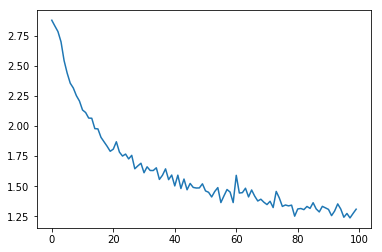

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## Define an evaluate function

Same as train without backprop

In [81]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

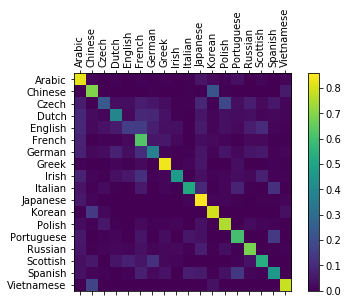

In [84]:
#keep track of correct guesses in confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through examples and record which are guessed correctly
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Running on user input

In [91]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))
    
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
        
predict('Busson')
predict('Muller')
predict('Lacrampe')


> Busson
(-1.94) French
(-1.98) Arabic
(-2.08) Dutch

> Muller
(-1.08) Scottish
(-1.33) German
(-2.25) English

> Lacrampe
(-0.29) French
(-2.40) Italian
(-2.87) German
